In [1]:
try:
    import davos
except:
    %pip install davos
davos.config.suppress_stdout = True

In [31]:
from bs4 smuggle BeautifulSoup                              # pip: beautifulsoup4==4.12.2
smuggle requests                                            # pip: requests==2.28.2
from tqdm smuggle tqdm                                      # pip: tqdm==4.65.0
smuggle textract                                            # pip: textract==1.6.4
smuggle Levenshtein                                         # pip: levenshtein
smuggle fuzzywuzzy                                          # pip: fuzzywuzzy==0.18.0
smuggle unidecode                                           # pip: Unidecode==1.3.6
smuggle pandas as pd                                        # pip: pandas==2.0.1
smuggle numpy as np                                         # pip: numpy==1.25.2
smuggle seaborn as sns                                      # pip: seaborn==0.12.2
from matplotlib smuggle pyplot as plt                       # pip: matplotlib==3.7.1
from IPython.display import Markdown
smuggle llama_cpp                                           # pip: llama-cpp-python==0.1.83
from langchain.llms smuggle LlamaCpp                        # pip: langchain==0.0.274
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain
from huggingface_hub smuggle hf_hub_download

from nltk.tokenize smuggle word_tokenize, sent_tokenize     # pip: nltk==3.8.1
from nltk import pos_tag

smuggle re
smuggle os
smuggle urllib
smuggle json
smuggle string
smuggle warnings
smuggle pickle
from glob smuggle glob as lsdir

from pathlib smuggle Path

from helpers smuggle format_filename, get_soup, get_pdf_text, get_doc_text, get_dialogue

# Template matching approach

In [32]:
def load_keywords(filename):
    with open(filename, 'r') as f:
        return set(line.strip() for line in f)

def sentence_tense(x):
  # source: https://stackoverflow.com/questions/30016904/determining-tense-of-a-sentence-python
  def tense_detect(tagged_sentence):        
    verb_tags = ['MD','MDF',
                'BE','BEG','BEN','BED','BEDZ','BEZ','BEM','BER',
                'DO','DOD','DOZ',
                'HV','HVG','HVN','HVD','HVZ',
                'VB','VBG','VBN','VBD','VBZ',
                'SH',
                'TO',                
                'JJ']
    
    verb_phrase = []
    for item in tagged_sentence:
        if item[1] in verb_tags:
            verb_phrase.append(item)

    grammar = r'''
            future perfect continuous passive:     {<MDF><HV><BEN><BEG><VBN|VBD>+}
            conditional perfect continuous passive:{<MD><HV><BEN><BEG><VBN|VBD>+}
            future continuous passive:             {<MDF><BE><BEG><VBN|VBD>+}   
            conditional continuous passive:        {<MD><BE><BEG><VBN|VBD>+}    
            future perfect continuous:             {<MDF><HV><BEN><VBG|HVG|BEG>+}   
            conditional perfect continuous:        {<MD><HV><BEN><VBG|HVG|BEG>+}
            past perfect continuous passive:       {<HVD><BEN><BEG><VBN|VBD>+}
            present perfect continuous passive:    {<HV|HVZ><BEN><BEG><VBN|VBD>+}
            future perfect passive:                {<MDF><HV><BEN><VBN|VBD>+}   
            conditional perfect passive:           {<MD><HV><BEN><VBN|VBD>+}    
            future continuous:                     {<MDF><BE><VBG|HVG|BEG>+ }   
            conditional continuous:                {<MD><BE><VBG|HVG|BEG>+  }   
            future indefinite passive:             {<MDF><BE><VBN|VBD>+ }
            conditional indefinite passive:        {<MD><BE><VBN|VBD>+  }
            future perfect:                        {<MDF><HV><HVN|BEN|VBN|VBD>+ }   
            conditional perfect:                   {<MD><HV><HVN|BEN|VBN|VBD>+  }   
            past continuous passive:               {<BED|BEDZ><BEG><VBN|VBD>+}  
            past perfect continuous:               {<HVD><BEN><HVG|BEG|VBG>+}   
            past perfect passive:                  {<HVD><BEN><VBN|VBD>+}
            present continuous passive:            {<BEM|BER|BEZ><BEG><VBN|VBD>+}   
            present perfect continuous:            {<HV|HVZ><BEN><VBG|BEG|HVG>+}    
            present perfect passive:               {<HV|HVZ><BEN><VBN|VBD>+}
            future indefinite:                     {<MDF><BE|DO|VB|HV>+ }       
            conditional indefinite:                {<MD><BE|DO|VB|HV>+  }   
            past continuous:                       {<BED|BEDZ><VBG|HVG|BEG>+}           
            past perfect:                          {<HVD><BEN|VBN|HVD|HVN>+}
            past indefinite passive:               {<BED|BEDZ><VBN|VBD>+}   
            present indefinite passive:            {<BEM|BER|BEZ><VBN|VBD>+}            
            present continuous:                    {<BEM|BER|BEZ><BEG|VBG|HVG>+}            
            present perfect:                       {<HV|HVZ><BEN|HVD|VBN|VBD>+  }       
            past indefinite:                       {<DOD><VB|HV|DO>|<BEDZ|BED|HVD|VBN|VBD>+}        
            infinitive:                            {<TO><BE|HV|VB>+}
            present indefinite:                    {<DO|DOZ><DO|HV|VB>+|<DO|HV|VB|BEZ|DOZ|BER|HVZ|BEM|VBZ>+}    
            '''

    if len(verb_phrase) > 0:
      cp = nltk.RegexpParser(grammar)
      result = cp.parse(verb_phrase)
    else:
      result = []
    
    tenses_set = set()
    for node in result:
      if type(node) is nltk.tree.Tree:
        tenses_set.add(node.label())
    
    return tenses_set
    
  text = word_tokenize(x)
  tagged = pos_tag(text)
  return tense_detect(tagged)

def process_folder(folder_path, past_keywords_file, future_keywords_file):
    past_keywords = load_keywords(past_keywords_file)
    future_keywords = load_keywords(future_keywords_file)

    df_results = pd.DataFrame(columns=["filename", "past", "future"])
    sentence_dfs_dict = {}

    for filename in tqdm(os.listdir(folder_path)):
        if filename.endswith(".txt"):
            with open(os.path.join(folder_path, filename), 'r', encoding='utf-8') as f:
                text = f.read()
            
            # Remove extra whitespaces
            text = ' '.join(text.split())
            
            # Split into sentences
            sentences = sent_tokenize(text)
            
            # DataFrame to store sentence-wise analysis
            df = pd.DataFrame(columns=["content", "past", "future"])

            past_count, future_count = 0, 0
            for sentence in sentences:
                # Initialize counts for this sentence
                sentence_past_count = 0
                sentence_future_count = 0

                # Use your function to determine the tenses in the sentence
                tenses = sentence_tense(sentence)

                # Check for keywords
                for keyword in past_keywords:
                    if keyword in sentence.lower():
                        sentence_past_count += 1
                for keyword in future_keywords:
                    if keyword in sentence.lower():
                        sentence_future_count += 1

                # If there's no keyword bias, use the tense information
                if sentence_past_count == 0 and sentence_future_count == 0:
                    if 'past' in tenses:
                        sentence_past_count += 1
                    if 'future' in tenses:
                        sentence_future_count += 1

                past_count += sentence_past_count
                future_count += sentence_future_count

                # Append to the sentence-wise DataFrame
                new_row = pd.DataFrame({"content": [sentence], "past": [sentence_past_count], "future": [sentence_future_count]})
                df = df._append(new_row, ignore_index=True)

            # Store this df in the dictionary
            sentence_dfs_dict[filename] = df

            # Add to final results
            new_result_row = pd.DataFrame({"filename": [filename], "past": [past_count], "future": [future_count]})
            df_results = df_results._append(new_result_row, ignore_index=True)

    return df_results, sentence_dfs_dict

In [ ]:
past_keywords_fname = str(Path.cwd().parent.joinpath('data', 'past_keywords.txt'))
future_keywords_fname = str(Path.cwd().parent.joinpath('data', 'future_keywords.txt'))
chair_dir = Path.cwd().parent.joinpath('data', 'the_chair')

chair_results, chair_sentence_dfs = process_folder(chair_dir, past_keywords_fname, future_keywords_fname)

In [49]:
chair_sentence_dfs['the_chair_s1e1_transcript.txt'].query('past > 0 or future > 0').head(50).iloc[0]

content    In a couple of minutes, we’ll know if that was...
past                                                       1
future                                                     0
Name: 22, dtype: object

## Set up Llama 2 model and "tense counter" prompt

In [9]:
# download llama-2 70B weights
model = 'TheBloke/Llama-2-70B-Orca-200k-GGUF'
weights_fname = 'llama-2-70b-orca-200k.Q5_K_M.gguf'

path = hf_hub_download(repo_id=model, filename=weights_fname)
llm = LlamaCpp(model_path=path, max_tokens=16384, n_gpu_layers=1, f16_kv=True, verbose=False, top_p=1, temperature=0.10, cache=False, n_batch=32)

# set up prompt
prompt_file = Path.cwd().parent.joinpath('data', 'prompt.txt')
with open(prompt_file, 'r') as f:
    prompt_template = f.read()
prompt = PromptTemplate.from_template(prompt_template)

# set up chain
get_tenses = LLMChain(llm=llm, prompt=prompt)

llama_model_loader: loaded meta data with 16 key-value pairs and 723 tensors from /Users/jmanning/.cache/huggingface/hub/models--TheBloke--Llama-2-70B-Orca-200k-GGUF/snapshots/83f775f4a07a3b5ae1b7ae94dab9ca1b0c57c641/llama-2-70b-orca-200k.Q5_K_M.gguf (version GGUF V1 (support until nov 2023))
llama_model_loader: - tensor    0:                token_embd.weight q5_K     [  8192, 32000,     1,     1 ]
llama_model_loader: - tensor    1:              blk.0.attn_q.weight q5_K     [  8192,  8192,     1,     1 ]
llama_model_loader: - tensor    2:              blk.0.attn_k.weight q5_K     [  8192,  1024,     1,     1 ]
llama_model_loader: - tensor    3:              blk.0.attn_v.weight q6_K     [  8192,  1024,     1,     1 ]
llama_model_loader: - tensor    4:         blk.0.attn_output.weight q5_K     [  8192,  8192,     1,     1 ]
llama_model_loader: - tensor    5:            blk.0.ffn_gate.weight q5_K     [  8192, 28672,     1,     1 ]
llama_model_loader: - tensor    6:              blk.0.ffn_

In [22]:
chunk_size = 1

def generate_responses_by_chunk(data_folder, chunk_size=20, max_files=None):    
    # Initialize variables
    all_responses = pd.DataFrame()
    all_errors = []

    # Calculate total number of chunks for tqdm
    total_chunks = 0
    for file in os.listdir(data_folder)[:max_files]:
        if file.endswith('.txt'):
            with open(os.path.join(data_folder, file), 'r') as f:
                text = f.read()
            
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            sentences = [' '.join(s.strip().split()) for s in sentences if len(s.strip()) > 0]
            total_chunks += -(-len(sentences) // chunk_size)

    # Initialize tqdm
    pbar = tqdm(total=total_chunks)
    
    # Start generating responses
    for file in os.listdir(data_folder)[:max_files]:
        if not file.endswith('.txt'):
            continue

        pkl_filename = f"{file[:-4]}_chunk{chunk_size}.pkl"
        pkl_filepath = os.path.join(data_folder, pkl_filename)

        if os.path.exists(pkl_filepath):
            # Load existing data
            with open(pkl_filepath, 'rb') as f:
                responses_df, file_errors = pickle.load(f)
        else:
            # Read and chunk file
            with open(os.path.join(data_folder, file), 'r') as f:
                text = f.read()
            
            sentences = re.split(r'(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?)\s', text)
            sentences = [' '.join(s.strip().split()) for s in sentences if len(s.strip()) > 0]
            
            chunks = [sentences[i:i + chunk_size] for i in range(0, len(sentences), chunk_size)]
            responses_df = pd.DataFrame(columns=['file', 'chunk_idx', 'response'])
            file_errors = []
            
            # Generate responses for each chunk
            for i, chunk in enumerate(chunks):
                response = get_tenses(' '.join(chunk))                
                responses_df = responses_df._append(pd.DataFrame({'file': [file], 'chunk_idx': [i], 'response': [response]}), ignore_index=True)
                pbar.update(1)

            # Save chunk responses to a pickle file
            with open(pkl_filepath, 'wb') as f:
                pickle.dump((responses_df, file_errors), f)
        
        # Append responses and errors
        all_responses = all_responses._append(responses_df, ignore_index=True)
        all_errors.extend([(file, *error_tuple) for error_tuple in file_errors])
        
    pbar.close()
    return all_responses, all_errors

Compare manually vs. automatically tagged references from *The Chair*

In [23]:
# fill in proportions for manual reference counts
ref_fname = str(Path.cwd().parent.joinpath('data', 'the_chair', 'the_chair_manual_reference_counts.csv'))
manual = pd.read_csv(ref_fname)
manual['Total'] = manual['Past'] + manual['Future']

# # compute proportions
# manual['p(Past)'] = manual['Past'] / manual['Total']
# manual['p(Future)'] = manual['Future'] / manual['Total']

manual.reset_index(inplace=True)
manual['Episode'] = manual['index'] + 1
manual.drop(['index', 'Total'], axis=1, inplace=True)

manual = manual.melt(var_name='tense', value_name='count', id_vars=['Episode'])
manual.sort_values(['Episode'], inplace=True)
manual.reset_index(inplace=True, drop=True)
manual['proportion'] = manual['count'] / manual.groupby('Episode')['count'].transform('sum')
manual

,Episode,tense,count,proportion
0,1,Past,60,0.769231
1,1,Future,18,0.230769
2,2,Past,30,0.681818
3,2,Future,14,0.318182
4,3,Past,43,0.565789
5,3,Future,33,0.434211
6,4,Past,31,0.596154
7,4,Future,21,0.403846
8,5,Past,36,0.765957
9,5,Future,11,0.234043


In [24]:
chair_dir = Path.cwd().parent.joinpath('data', 'the_chair')

chair_results_fname = chair_dir.joinpath(f'the_chair_gpt_responses_c{chunk_size}.pkl')

if chair_results_fname.exists():
    with open(chair_results_fname, 'rb') as f:
        auto, errors = pickle.load(f)
else:
    auto, errors = generate_responses_by_chunk(chair_dir, chunk_size=chunk_size)
    with open(chair_results_fname, 'wb') as f:
        pickle.dump((auto, errors), f)

ValueError: Requested tokens (558) exceed context window of 512

In [193]:
def fix_json_string(bad_json_str):
    result = []
    is_key = True  # Tracks if we are within a key
    is_value = False  # Tracks if we are within a value
    is_escaped = False  # Tracks if the current character is escaped (preceded by a backslash)
    quote_type = None  # Tracks the type of quote (' or ") for the current key or value

    for c in bad_json_str:
        if c == '\\':  # Escape character
            is_escaped = not is_escaped
            result.append(c)
        elif (c == '"' or c == "'") and not is_escaped:  # Quote character
            if quote_type is None:  # Starting a new quoted section
                quote_type = c
                result.append('"')  # Always use double quotes in the output
            elif quote_type == c:  # Ending the current quoted section
                quote_type = None
                result.append('"')  # Always use double quotes in the output
                is_key = not is_key  # Toggle is_key because keys and values alternate
                is_value = not is_value  # Toggle is_value as well
            else:
                result.append(c)  # Leave other quotes untouched
        elif c == ':' and quote_type is None:  # Colon (only meaningful outside of quotes)
            is_key = False
            is_value = True
            result.append(c)
        elif c == ',' and quote_type is None:  # Comma (only meaningful outside of quotes)
            is_key = True
            is_value = False
            result.append(c)
        else:  # All other characters
            result.append(c)

        # Reset the escape flag if the current character was not a backslash
        if c != '\\':
            is_escaped = False

    # Join the list into a single string and attempt to parse it as JSON
    fixed_json_str = ''.join(result)
    try:
        fixed_json = json.loads(fixed_json_str)
        return fixed_json
    except json.JSONDecodeError as e:
        print("Failed to decode JSON:", e)
        return None

In [194]:
errors = []
parsed_responses = []

for i, row in auto.iterrows():
    parsed_response = None

    try:
        html = row['response']
        parsed = BeautifulSoup(html).get_text()
        parsed_response = fix_json_string(parsed)
    except:
        pass
    
    if parsed_response is None:
        errors.append({'file': row['file'], 'chunk_idx': row['chunk_idx'], 'response': row['response'], 'iloc': i})
        parsed_responses.append(None)
    else:
        parsed_responses.append(parsed_response)

drop_indices = [e['iloc'] for e in errors]
auto.drop(drop_indices, inplace=True)
auto.reset_index(inplace=True, drop=True)

auto['response'] = [p for p in parsed_responses if p is not None]

past = lambda response: np.sum([int(x['P']) for x in response.values()])
future = lambda response: np.sum([int(x['F']) for x in response.values()])
episode = lambda filename: int(filename.split('_')[2][3])

auto['Past'] = auto['response'].apply(past)
auto['Future'] = auto['response'].apply(future)
auto['Episode'] = auto['file'].apply(episode)

auto = auto.groupby('Episode').agg({'Past': 'sum', 'Future': 'sum'}).reset_index()
auto = auto.melt(var_name='tense', value_name='count', id_vars=['Episode'])
auto.sort_values(['Episode'], inplace=True)
auto.reset_index(inplace=True, drop=True)
auto['proportion'] = auto['count'] / auto.groupby('Episode')['count'].transform('sum')
auto

Failed to decode JSON: Unterminated string starting at: line 1 column 364 (char 363)
Failed to decode JSON: Extra data: line 16 column 1 (char 1188)


,Episode,tense,count,proportion
0,1,Past,80,0.740741
1,1,Future,28,0.259259
2,2,Past,79,0.711712
3,2,Future,32,0.288288
4,3,Past,113,0.748344
5,3,Future,38,0.251656
6,4,Past,87,0.783784
7,4,Future,24,0.216216
8,5,Past,107,0.804511
9,5,Future,26,0.195489


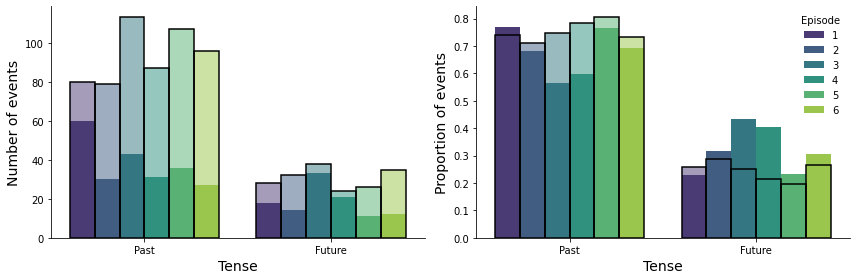

In [195]:
fig, axes = plt.subplots(figsize=(12, 4), ncols=2)

# show counts
sns.barplot(data=manual, x='tense', y='count', hue='Episode', palette='viridis', ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', palette='viridis', alpha=0.5, ax=axes[0])
sns.barplot(data=auto, x='tense', y='count', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[0])
axes[0].get_legend().remove()

axes[0].set_xlabel('Tense', fontsize=14)
axes[0].set_ylabel('Number of events', fontsize=14)
sns.despine(top=True, right=True)

# show proportions
sns.barplot(data=manual, x='tense', y='proportion', hue='Episode', palette='viridis', ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', palette='viridis', alpha=0.5, ax=axes[1])
sns.barplot(data=auto, x='tense', y='proportion', hue='Episode', fill=False, edgecolor='k', linewidth=1.5, ax=axes[1])
handles, labels = axes[1].get_legend_handles_labels()
axes[1].legend(loc='upper right', title='Episode', handles=handles[:6], labels=labels[:6], frameon=False)

axes[1].set_xlabel('Tense', fontsize=14)
axes[1].set_ylabel('Proportion of events', fontsize=14)
sns.despine(top=True, right=True)

plt.tight_layout()
fig.savefig('the_chair_events.pdf', bbox_inches='tight')

# Download datasets

## [Internet Movie Script Database (IMSDb)](https://imsdb.com/)

In [165]:
imsdb_dir = str(Path.cwd().parent.joinpath('data').joinpath('imsdb'))
if not os.path.exists(imsdb_dir):
  os.makedirs(imsdb_dir)

In [166]:
def get_imsdb():
    ALL_URL = "https://imsdb.com/all-scripts.html"
    BASE_URL = "https://imsdb.com"
    SOURCE = "imsdb"

    def get_script_from_url(script_url):
        text = ""

        try:
            if script_url.endswith('.pdf'):
                text = get_pdf_text(script_url, os.path.join(SOURCE, file_name))
                return text

            if script_url.endswith('.html'):
                script_soup = get_soup(
                    script_url)
                if script_soup == None:
                    return text
                if len(script_soup.find_all('td', class_="scrtext")) < 1:
                    return ""
                script_text = script_soup.find_all(
                    'td', class_="scrtext")[0].pre

                if script_text:
                    script_text = script_soup.find_all(
                        'td', class_="scrtext")[0].pre.pre
                    if script_text:
                        text = script_text.get_text()

                    else:
                        script_text = script_soup.find_all(
                            'td', class_="scrtext")[0].pre
                        text = script_text.get_text()
        except Exception as err:
            # print(script_url)
            # print(err)
            text = ""

        return text

    def get_script_url(movie):
        script_page_url = movie.contents[0].get('href')
        name = movie.contents[0].text
        movie_name = script_page_url.split("/")[-1].strip('Script.html')

        script_page_soup = get_soup(BASE_URL + urllib.parse.quote(script_page_url))
        if script_page_soup == None:
            return "", name
        paras = script_page_soup.find_all('p', align="center")
        if len(paras) < 1:
            return "", ""
        script_url = paras[0].contents[0].get('href')

        return script_url, name

    soup = get_soup(ALL_URL)
    movielist = soup.find_all('p')

    for movie in tqdm(movielist, desc=SOURCE):
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            script_url, name = get_script_url(movie)
    
        if script_url == "":
            continue
        
        script_url = BASE_URL + urllib.parse.quote(script_url)
        file_name = format_filename(name)

        if os.path.exists(os.path.join(imsdb_dir, file_name + '.txt')):
            continue
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            text = get_script_from_url(script_url)

        if text == "" or name == "":
            continue
        
        with open(os.path.join(imsdb_dir, file_name + '.txt'), 'w', errors="ignore") as out:
            out.write(text)

In [167]:
if os.path.exists(imsdb_dir):
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]
else:
    fnames = []

if len(fnames) < 1000:
    get_imsdb()
    fnames = [f for f in os.listdir(imsdb_dir) if f.endswith('.txt')]

print(f'Found {len(fnames)} IMSDB scripts.')

Found 1127 IMSDB scripts.


Display a randomly chosen excerpt from a randomly chosen transcript

In [168]:
sample = np.random.choice(fnames)

with open(os.path.join(imsdb_dir, sample), 'r') as f:
    lines = f.readlines()
    lines = [x.strip() for x in lines if len(x.strip()) > 0]

    # choose a 10 line snippet at random
    start = np.random.randint(0, len(lines) - 10)
    snippet = lines[start:start+10]

Markdown(f'**Excerpt from {sample}:**\n\n' + '\n\n'.join(snippet))

**Excerpt from Martian-The.txt:**

I vote yes.

VOGEL

If we do this, it would be over nine

hundred days of space. That is enough

space for one life.

(THEN)

Yes.

Beck thinks about it long and hard. Then:

BECK

Let's go get him.

In [211]:
Path(imsdb_dir)

PosixPath('/Users/jmanning/prediction-retrodiction-paper/data/imsdb')

In [213]:
imsdb_results_fname = Path(imsdb_dir).joinpath(f'imsdb_gpt_responses_c{chunk_size}.pkl')

if imsdb_results_fname.exists():
    with open(imsdb_results_fname, 'rb') as f:
        auto, errors = pickle.load(f)
else:
    auto, errors = generate_gpt_responses_by_chunk(imsdb_dir, prompt_file=prompt_file, api_key_file=api_key_file, chunk_size=chunk_size, max_files=3, model=model)
    #with open(imsdb_results_fname, 'wb') as f:
    #    pickle.dump((auto, errors), f)

 13%|█▎        | 112/844 [19:54<2:28:33, 12.18s/it]

Timeout: Request timed out: HTTPSConnectionPool(host='api.openai.com', port=443): Read timed out. (read timeout=600)